In [3]:
from MVPAnalyzer import Analyzer
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

mvpa = Analyzer('/home/maxw/Documents/ESSTECH25/MVP300_DATA/Stationary_Profiling/',subdirs=True)

# mvpa.help()

mvpa.load_mvp_data() 

# mvpa.load_ctd_data('C:/Users/maxim/Documents/INGE CNRS/ESSTECH25/BATHYSONDE/DATA/TRAIT/CNV/')

# mvpa.keep_selected_profiles([0, 10, 8, 2], [0, 2, 4, 8])
mvpa.keep_selected_profiles([0,10,8,2])

mvpa.viscous_heating_correction()
print('Viscous heating correction done.')
mvpa.filtering_surface_waves()
print('Surface wave filtering done.')
mvpa.temporal_lag_correction(correction=True)
print('Temporal lag correction done.')

/home/maxw/miniconda3/envs/oceanapp/lib/python3.11/site-packages/seabird/cnv.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Found 6 MVP files in the directory: /home/maxw/Documents/ESSTECH25/MVP300_DATA/Stationary_Profiling/
MVP data loaded successfully.
Viscous heating correction done.
MVP data loaded successfully.
Viscous heating correction done.
Surface wave filtering done.
Surface wave filtering done.
Temporal lag correction done.
Temporal lag correction done.


In [4]:
import numpy as np 
import gsw
from scipy.optimize import minimize
from fastdtw import fastdtw
from tqdm import tqdm
import time
import similaritymeasures

def compute_vertical_velocity(P, fs, window=20):
    v_z = np.gradient(P, 1/fs,axis=1)


    # smooth speed
    for i in range(v_z.shape[0]):
        v_z[i,:] = np.convolve(v_z[i,:], np.ones(2*window+1)/(2*window+1), mode='same')
    
    return np.abs(v_z)

def T_correction(T,V,Fn,params_r):

    alpha_o = params_r[0]
    alpha_s = params_r[1]
    tau_o = params_r[2]
    tau_s = params_r[3]

    # Éviter les divisions par zéro et limiter les valeurs extrêmes
    V_safe = np.maximum(V, 0.01)  # Vitesse minimum 0.01 m/s
    
    alpha = alpha_o + alpha_s / V_safe
    tau = tau_o + tau_s / np.sqrt(V_safe)

    # Coefficients pour l'équation récursive
    a = 4*Fn*alpha*tau / (1 + 4*Fn*tau)
    b = 1 - 2*a/alpha

    # Limiter les coefficients pour éviter l'instabilité
    a = np.clip(a, -1, 1)
    b = np.clip(b, -2, 2)

    T_corr = np.copy(T)
    # Application récursive: T_corr[n] = b[n]*T_corr[n-1] + a[n]*(T[n] - T[n-1])
    for i in range(1, len(T)):
        if np.isfinite(b[i]) and np.isfinite(a[i]):
            T_corr[i] = b[i] * T_corr[i-1] + a[i] * (T[i] - T[i-1])
        else:
            T_corr[i] = T[i]  # Pas de correction si coefficients invalides

    return T_corr


def data_correction(T,V,Fn,params_r):

    alpha_o = params_r[:,0]
    alpha_s = params_r[:,1]
    tau_o = params_r[:,2]
    tau_s = params_r[:,3]
    T_corr = np.copy(T)

    for i in range(0,len(V),2):
        # Profil descendant
        V_safe = np.maximum(V[i], 0.01)
        alpha = alpha_o[i//2] + alpha_s[i//2] / V_safe
        tau = tau_o[i//2] + tau_s[i//2] / np.sqrt(V_safe)

        a = 4*Fn*alpha*tau / (1 + 4*Fn*tau)
        b = 1 - 2*a/alpha
        
        # Limiter les coefficients
        a = np.clip(a, -1, 1)
        b = np.clip(b, -2, 2)
        
        # Application récursive
        for j in range(1, len(T[i])):
            if np.isfinite(b[j]) and np.isfinite(a[j]):
                T_corr[i,j] = b[j] * T_corr[i,j-1] + a[j] * (T[i,j] - T[i,j-1])

        # Profil remontant
        if i+1 < len(V):
            V_safe = np.maximum(V[i+1], 0.01)
            alpha = alpha_o[i//2] + alpha_s[i//2] / V_safe
            tau = tau_o[i//2] + tau_s[i//2] / np.sqrt(V_safe)

            a = 4*Fn*alpha*tau / (1 + 4*Fn*tau)
            b = 1 - 2*a/alpha
            
            # Limiter les coefficients
            a = np.clip(a, -1, 1)
            b = np.clip(b, -2, 2)
            
            # Application récursive
            for j in range(1, len(T[i+1])):
                if np.isfinite(b[j]) and np.isfinite(a[j]):
                    T_corr[i+1,j] = b[j] * T_corr[i+1,j-1] + a[j] * (T[i+1,j] - T[i+1,j-1])
        
    return T_corr




def find_params(T,C,P,Fn,V,init_val,bnds):

    params = np.zeros((len(V)//2,4))
    params[:] = np.nan
    for i in tqdm(range(0,len(P),2)):

        result = minimize(objective_function, init_val,args=(T,C,P,V,i,Fn), bounds=bnds, method='SLSQP')
        params[i//2] = result.x


    return params


def objective_function(params,T,C,P,V,i,Fn):

    T_down = T_correction(T[i],V[i],Fn,params)
    T_up = T_correction(T[i+1],V[i+1],Fn,params)
    # Ordre correct: gsw.SP_from_C(conductivity, temperature, pressure)
    S_down = gsw.SP_from_C(C[i], T_down, P[i])
    S_up = gsw.SP_from_C(C[i+1], T_up, P[i+1])
    
    TS_down = np.vstack((T_down,S_down)).T
    TS_up = np.vstack((T_up,S_up)).T
    mask = ~np.isnan(TS_up).any(axis=1) & ~np.isnan(TS_down).any(axis=1)
    TS_down = TS_down[mask]
    TS_up = TS_up[mask]

    # Vérifier qu'il y a assez de points valides
    if len(TS_down) < 10 or len(TS_up) < 10:
        return 1e6  # Pénalité si pas assez de données
    
    try:
        dist = similaritymeasures.area_between_two_curves(TS_down, TS_up)
        return dist if np.isfinite(dist) else 1e6
    except:
        return 1e6


def interp_data(T, C, P, V, step=0.25):

    n_prof = T.shape[0]
    # Plage commune à tous les profils
    min_depth = np.nanmax([np.nanmin(P[i]) for i in range(n_prof)])
    max_depth = np.nanmin([np.nanmax(P[i]) for i in range(n_prof)])
    depth = np.arange(min_depth, max_depth, step)
    n_depth = len(depth)

    P_interp = np.zeros((n_prof, n_depth))
    T_interp = np.zeros((n_prof, n_depth))
    C_interp = np.zeros((n_prof, n_depth))
    V_interp = np.zeros((n_prof, n_depth))

    for i in range(n_prof):
        P_interp[i] = depth
        # Si profil impair (remontée), on flip
        if i % 2 == 1:
            P_interp[i] = depth
            T_interp[i] = np.interp(depth, np.flip(P[i]), np.flip(T[i]), left=np.nan, right=np.nan)
            C_interp[i] = np.interp(depth, np.flip(P[i]), np.flip(C[i]), left=np.nan, right=np.nan)
            V_interp[i] = np.interp(depth, np.flip(P[i]), np.flip(V[i]), left=np.nan, right=np.nan)
        else:
            T_interp[i] = np.interp(depth, P[i], T[i], left=np.nan, right=np.nan)
            C_interp[i] = np.interp(depth, P[i], C[i], left=np.nan, right=np.nan)
            V_interp[i] = np.interp(depth, P[i], V[i], left=np.nan, right=np.nan)

    return T_interp, C_interp, P_interp, V_interp

In [5]:
# import thermal_mass_corr as tm
%matplotlib inline

T = mvpa.TEMP_align.copy()
C = mvpa.COND_align.copy()
P = mvpa.PRES0.copy()
t = mvpa.TIME0.copy()
fs = mvpa.freq_echant
V = compute_vertical_velocity(P, fs)


T,C,P,V = interp_data(T,C,P,V)


init_val = (0.043, 1.37, -0.26, 1.53)
bnds = ((-2, 2), (0, 3), (-5, 5), (0, 5))

params = find_params(T,C,P,fs,V,init_val,bnds)

T_corr = data_correction(T,V,fs,params)

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_6959/1005380400.py:44: RuntimeWarning: overflow encountered in scalar multiply
  T_corr[i] = b[i] * T_corr[i-1] + a[i] * (T[i] - T[i-1])
/home/maxw/miniconda3/envs/oceanapp/lib/python3.11/site-packages/gsw/_wrapped_ufuncs.py:6524: RuntimeWarning: overflow encountered in sp_from_c
  return _gsw_ufuncs.sp_from_c(C, t, p)
/home/maxw/miniconda3/envs/oceanapp/lib/python3.11/site-packages/gsw/_wrapped_ufuncs.py:6524: RuntimeWarning: invalid value encountered in sp_from_c
  return _gsw_ufuncs.sp_from_c(C, t, p)
100%|██████████| 4/4 [00:24<00:00,  6.18s/it]


In [6]:
print(params)

[[-4.07221592e-04  0.00000000e+00  1.17166493e-03  0.00000000e+00]
 [ 4.30000000e-02  1.37000000e+00 -2.60000000e-01  1.53000000e+00]
 [ 4.30000000e-02  1.37000000e+00 -2.60000000e-01  1.53000000e+00]
 [ 4.30000000e-02  1.37000000e+00 -2.60000000e-01  1.53000000e+00]]


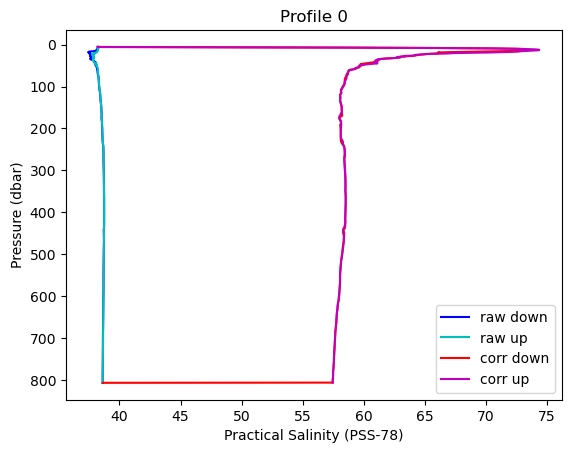

In [7]:

S_corr = gsw.SP_from_C(C, T_corr, P)
S_raw = gsw.SP_from_C(C, T, P)


id = 0
%matplotlib inline
plt.figure()
plt.plot(S_raw[id],P[id],'b',label='raw down')
plt.plot(S_raw[id+1],P[id+1],'c',label='raw up')
plt.plot(S_corr[id],P[id],'r',label='corr down')
plt.plot(S_corr[id+1],P[id+1],'m',label='corr up')
plt.gca().invert_yaxis()
plt.legend()
plt.title(f'Profile {id}')
plt.xlabel('Practical Salinity (PSS-78)')
plt.ylabel('Pressure (dbar)')
plt.show()

In [30]:
# Debug: vérifions les données avant visualisation
print("Shapes:")
print(f"T shape: {T.shape}, C shape: {C.shape}, P shape: {P.shape}")
print(f"V shape: {V.shape}")
print(f"T_corr shape: {T_corr.shape}")

print("\nT ranges:")
for i in range(min(4, T.shape[0])):
    print(f"Profile {i}: T range [{np.nanmin(T[i]):.3f}, {np.nanmax(T[i]):.3f}]")
    print(f"Profile {i}: T_corr range [{np.nanmin(T_corr[i]):.3f}, {np.nanmax(T_corr[i]):.3f}]")
    print(f"Profile {i}: V range [{np.nanmin(V[i]):.3f}, {np.nanmax(V[i]):.3f}]")

print("\nVérification des valeurs infinies/NaN:")
print(f"T_corr has inf: {np.any(np.isinf(T_corr))}")
print(f"T_corr has nan: {np.any(np.isnan(T_corr))}")
print(f"V has zeros or very small values: {np.any(V < 1e-6)}")

Shapes:
T shape: (8, 3208), C shape: (8, 3208), P shape: (8, 3208)
V shape: (8, 3208)
T_corr shape: (8, 3208)

T ranges:
Profile 0: T range [13.582, 24.759]
Profile 0: T_corr range [-0.000, 24.759]
Profile 0: V range [0.568, 0.960]
Profile 1: T range [13.581, 25.284]
Profile 1: T_corr range [-0.000, 25.284]
Profile 1: V range [0.106, 0.879]
Profile 2: T range [13.397, 23.070]
Profile 2: T_corr range [-22.589, 23.070]
Profile 2: V range [0.908, 1.303]
Profile 3: T range [13.394, 13.854]
Profile 3: T_corr range [nan, nan]
Profile 3: V range [0.920, 1.074]

Vérification des valeurs infinies/NaN:
T_corr has inf: False
T_corr has nan: True
V has zeros or very small values: False


/tmp/ipykernel_35173/3500398795.py:10: RuntimeWarning: All-NaN slice encountered
  print(f"Profile {i}: T_corr range [{np.nanmin(T_corr[i]):.3f}, {np.nanmax(T_corr[i]):.3f}]")


In [31]:
# Version simplifiée et plus stable de la correction thermique
def T_correction_simple(T, V, Fn, params_r):
    """Version simplifiée basée sur un filtre au lieu de récursion"""
    alpha_o, alpha_s, tau_o, tau_s = params_r
    
    # Vitesse sécurisée
    V_safe = np.maximum(V, 0.1)  # Vitesse minimum plus élevée
    
    # Paramètres thermal mass
    alpha = np.abs(alpha_o) + np.abs(alpha_s) / V_safe
    tau = np.abs(tau_o) + np.abs(tau_s) / np.sqrt(V_safe)
    
    # Limiter les paramètres à des valeurs raisonnables
    alpha = np.clip(alpha, 0.001, 0.5)
    tau = np.clip(tau, 0.1, 5.0)
    
    # Simple correction basée sur la dérivée
    dT_dt = np.gradient(T)
    correction = alpha * tau * dT_dt / (1 + tau * Fn)
    T_corr = T + correction
    
    return T_corr

def data_correction_simple(T, V, Fn, params_r):
    """Version simplifiée pour tous les profils"""
    T_corr = np.copy(T)
    
    for i in range(len(V)):
        profile_params = params_r[i//2] if i//2 < len(params_r) else params_r[-1]
        T_corr[i] = T_correction_simple(T[i], V[i], Fn, profile_params)
        
    return T_corr

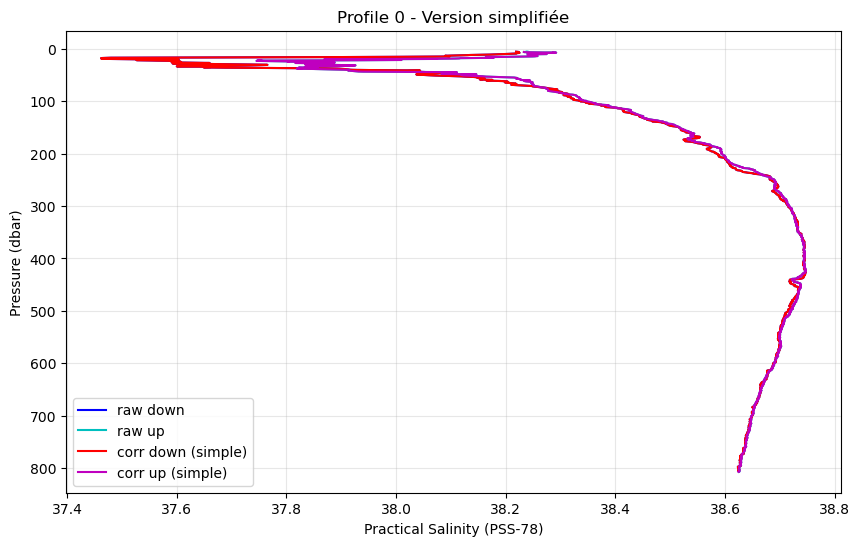

Ranges après correction simplifiée:
Profile 0: T_corr range [13.583, 24.759]
Profile 1: T_corr range [13.581, 25.141]
Profile 2: T_corr range [13.397, 23.069]
Profile 3: T_corr range [13.394, 13.854]


In [32]:
# Test de la version simplifiée
T_corr_simple = data_correction_simple(T, V, fs, params)

# Calcul des salinités
S_corr_simple = gsw.SP_from_C(C, T_corr_simple, P)
S_raw = gsw.SP_from_C(C, T, P)

# Visualisation
id = 0
plt.figure(figsize=(10, 6))
plt.plot(S_raw[id], P[id], 'b', label='raw down')
plt.plot(S_raw[id+1], P[id+1], 'c', label='raw up')
plt.plot(S_corr_simple[id], P[id], 'r', label='corr down (simple)')
plt.plot(S_corr_simple[id+1], P[id+1], 'm', label='corr up (simple)')
plt.gca().invert_yaxis()
plt.legend()
plt.title(f'Profile {id} - Version simplifiée')
plt.xlabel('Practical Salinity (PSS-78)')
plt.ylabel('Pressure (dbar)')
plt.grid(True, alpha=0.3)
plt.show()

print("Ranges après correction simplifiée:")
for i in range(min(4, T.shape[0])):
    print(f"Profile {i}: T_corr range [{np.nanmin(T_corr_simple[i]):.3f}, {np.nanmax(T_corr_simple[i]):.3f}]")